# 2️⃣ Pretrained ResNet-16
    ✅ Pretrained on: ImageNet
    ✅ Feature Extraction Power: Very strong due to residual connections
    ✅ How it Works:

        Uses skip connections (residual connections) → Helps in training deep networks.
        Prevents vanishing gradient problem → Deep networks train effectively.
        Extracts deep hierarchical features for better classification.

In [7]:
import numpy as np
import os
import joblib
import time
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Enabling mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2050, compute capability 8.6


In [3]:
# Set Data Directory
data_dir = r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\preprocessed'
img_size = (224,224)
batch_size = 32

In [11]:
# Defining output directory for features
output_dir = 'Extracted_features'
os.makedirs(output_dir, exist_ok=True)

# ResNet16 + SVM

# Loading the Pre-trained ResNet16 Model

In [12]:
def extract_features_using_resnet16():
    print('Starting feature extraction using ResNet16...')
    start_time =time.time()

    # Loading the pre-trained Model
    model = ResNet50V2(weights = 'imagenet', include_top = False, pooling = 'avg')

    # Ensure data directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Dataset directory '{data_dir}' not found.")
        return None, None

    try:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet)
        generator = datagen.flow_from_directory(
            data_dir,
            target_size = img_size,
            batch_size = batch_size,
            class_mode = 'sparse',
            shuffle = False
        )
    
        features = model.predict(generator, verbose=1)
        labels = generator.classes
    
        feature_filename = os.path.join(output_dir, 'features_ResNet16.npy')
        label_filename = os.path.join(output_dir, 'labels_ResNet16.npy')
    
        np.save(feature_filename, features)
        np.save(label_filename, labels)
    
        print(f'Feature extraction complete for ResNet16. Time Taken:{time.time()-start_time:.2f}seconds')
        print(f'Saved features to {feature_filename} and labels to {label_filename}')
    
        return features, labels
    except Exception as e:
        print(f'Error during feature Extraction: {e}')
        return None, None

# Extracting Features

In [13]:
features,labels = extract_features_using_resnet16()

Starting feature extraction using ResNet16...
Found 92501 images belonging to 5 classes.
2891/2891 [==============================] - 223s 77ms/step
Feature extraction complete for ResNet16. Time Taken:228.98seconds
Saved features to Extracted_features\features_ResNet16.npy and labels to Extracted_features\labels_ResNet16.npy


In [14]:
# Loadding the Extracted Features and Labels
feature_filename = r"C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\notebooks\Extracted_features\features_ResNet16.npy"
label_filename = r"C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\notebooks\Extracted_features\labels_ResNet16.npy"

In [15]:
features

array([[0.1473  , 0.4402  , 0.144   , ..., 2.396   , 0.0437  , 0.04144 ],
       [0.1416  , 0.3577  , 0.11694 , ..., 1.843   , 0.0739  , 0.      ],
       [0.4016  , 1.271   , 0.03482 , ..., 2.7     , 1.001   , 0.02063 ],
       ...,
       [0.01747 , 0.2678  , 0.0279  , ..., 2.033   , 0.9814  , 0.      ],
       [0.08856 , 0.0051  , 1.426   , ..., 0.0916  , 2.059   , 0.02466 ],
       [0.404   , 0.2479  , 0.006317, ..., 1.456   , 0.1371  , 0.1304  ]],
      dtype=float16)

In [16]:
labels

array([0, 0, 0, ..., 4, 4, 4])

In [17]:
# Checking Class Distribution
unique, counts = np.unique(labels, return_counts=True)
print('Class Distribution:',dict(zip(unique,counts)))

Class Distribution: {0: 68953, 1: 4634, 2: 15151, 3: 1259, 4: 2504}


In [18]:
# Printing Feature Shapes
print('Feature Shape:',features.shape)
print('labels Shape:',labels.shape)

Feature Shape: (92501, 2048)
labels Shape: (92501,)


In [19]:
# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the Features and Labels into Training(70%), Testing(15%), Validation(15%) Sets

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, labels, test_size=0.3, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Reducing the dimensionality using PCA

In [21]:
start_time = time.time()
pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
end_time = time.time()
print(f'Time Taken For Execution: {end_time - start_time:.2f}seconds')
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance retained: {explained_variance:.2f}")

Time Taken For Execution: 37.79seconds
Total variance retained: 0.76


In [22]:
# Saving the Preprocessing Objects
joblib.dump(scaler, r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\scaler_resnet16.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\scaler_resnet16.pkl']

In [23]:
joblib.dump(pca,r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\pca_resnet16.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\pca_resnet16.pkl']

# Training SVM classifier

# 1) Implementation of SVM that uses Stochastic Gradient Descent (SGD) for optimization.

In [24]:
sgd_svm = SGDClassifier(loss='hinge',max_iter=3000, tol=1e-3, random_state=42,n_jobs=-1, class_weight='balanced', verbose=1)
start_time = time.time()
sgd_svm.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SGD SVM Training Execution Time: {end_time - start_time:.2f}seconds')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1258.76, NNZs: 500, Bias: -4386.012175, T: 64750, Avg. loss: 377.037818
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 476.57, NNZs: 500, Bias: -1207.382079, T: 64750, Avg. loss: 215.923614
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 71.53, NNZs: 500, Bias: -4.565204, T: 64750, Avg. loss: 131.555271
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 143.51, NNZs: 500, Bias: -243.474501, T: 64750, Avg. loss: 171.706414
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 824.25, NNZs: 500, Bias: -3707.574084, T: 64750, Avg. loss: 240.607564
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 1006.86, NNZs: 500, Bias: -3999.972689, T: 129500, Avg. loss: 77.420180
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 259.68, NNZs: 500, Bias: -560.309029, T: 129500, Avg. loss: 46.069775
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 48.48, NNZs: 500, Bias: -76.841910, T: 129500, Avg. loss: 25.068382
Total training

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


# Evaluating SGD SVM on validation set

In [25]:
y_val_pred_sgd = sgd_svm.predict(X_val_pca)
val_accuracy_sgd = accuracy_score(y_val, y_val_pred_sgd)
print('Validation Accuracy (SGD SVM ):', val_accuracy_sgd)
print('Validation Classification Report (SGD SVM): \n', classification_report(y_val, y_val_pred_sgd))

Validation Accuracy (SGD SVM ): 0.6416114153934852
Validation Classification Report (SGD SVM): 
               precision    recall  f1-score   support

           0       0.83      0.78      0.80     10344
           1       0.09      0.13      0.10       695
           2       0.27      0.24      0.25      2273
           3       0.13      0.37      0.19       189
           4       0.28      0.47      0.35       375

    accuracy                           0.64     13876
   macro avg       0.32      0.40      0.34     13876
weighted avg       0.68      0.64      0.66     13876



# Evaluating SGD SVM on test set

In [26]:
y_test_pred_sgd = sgd_svm.predict(X_test_pca)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred_sgd)
print("Test Accuracy (SGD SVM):", test_accuracy_sgd)
print("Test Classification Report (SGD SVM):\n", classification_report(y_test, y_test_pred_sgd))

Test Accuracy (SGD SVM): 0.6416576576576577
Test Classification Report (SGD SVM):
               precision    recall  f1-score   support

           0       0.83      0.78      0.80     10343
           1       0.09      0.13      0.10       695
           2       0.27      0.24      0.25      2272
           3       0.12      0.37      0.19       189
           4       0.28      0.45      0.34       376

    accuracy                           0.64     13875
   macro avg       0.32      0.39      0.34     13875
weighted avg       0.68      0.64      0.66     13875



# Plotting the ROC-AUC Curve for SGD SVM

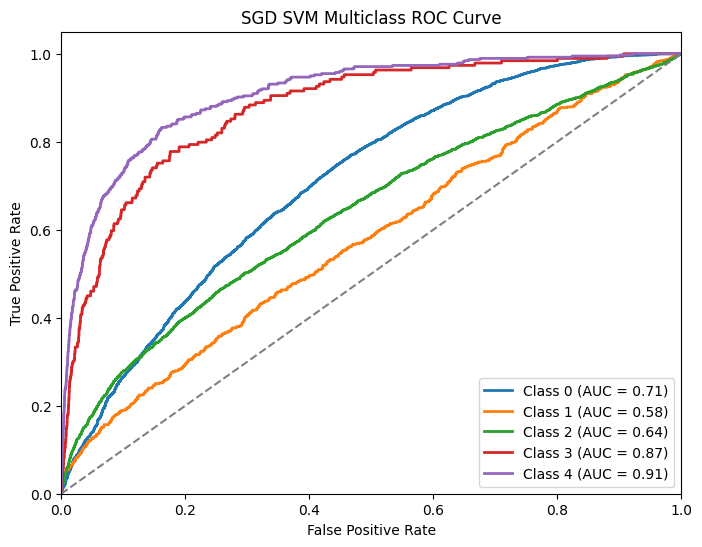

In [27]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
y_test_score_sgd = sgd_svm.decision_function(X_test_pca)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score_sgd[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGD SVM Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Saving the SGD SVM model
joblib.dump(sgd_svm,r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\sgd_svm_resnet16.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\sgd_svm_resnet16.pkl']

# 2) Implementation of SVM by finding the optimal hyperparameters

# Hyperparameter Tuning for Optimized SVM

In [31]:
param_grid = {'alpha': [0.0001, 0.001, 0.01], 'loss':['hinge'], 'penalty': ['l2','l1'], 'max_iter':[1000,2000]}
svm_grid = GridSearchCV(SGDClassifier(random_state=42, n_jobs=-1, class_weight= 'balanced'), param_grid, cv=2, n_jobs=-1, verbose=3)
start_time  = time.time()
svm_grid.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SVM Hyperparamter Tuning Execution Time: {end_time - start_time:.2f} seconds')

Fitting 2 folds for each of 12 candidates, totalling 24 fits
SVM Hyperparamter Tuning Execution Time: 637.95 seconds


# Training Optimized SVM Classifier 

In [32]:
svm_model = svm_grid.best_estimator_
start_time = time.time()
svm_model.fit(X_train_pca, y_train)
end_time = time.time()
print(f'SVM Training Execution Time: {end_time - start_time:.2f}seconds')

SVM Training Execution Time: 3.12seconds


# Evaluating on Validation Set

In [33]:
y_val_pred = svm_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy:', val_accuracy)
print('Test Classification Report:\n', classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7359469587777457
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     10344
           1       0.20      0.11      0.14       695
           2       0.41      0.17      0.24      2273
           3       0.15      0.37      0.21       189
           4       0.30      0.46      0.36       375

    accuracy                           0.74     13876
   macro avg       0.38      0.40      0.36     13876
weighted avg       0.70      0.74      0.71     13876



# Evaluating on Testing Set

In [34]:
y_test_pred = svm_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy:',test_accuracy)
print('Test Classification Report:\n', classification_report(y_test,y_test_pred))

Test Accuracy: 0.7372252252252253
Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     10343
           1       0.24      0.12      0.16       695
           2       0.41      0.17      0.24      2272
           3       0.14      0.33      0.20       189
           4       0.30      0.45      0.36       376

    accuracy                           0.74     13875
   macro avg       0.38      0.40      0.37     13875
weighted avg       0.70      0.74      0.71     13875



# Plotting the ROC-AUC Curve for optimized SVM

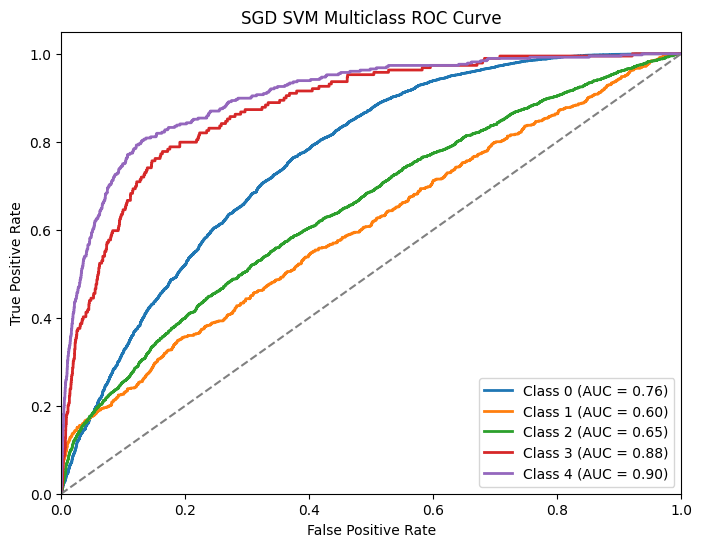

In [35]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
y_test_score_sgd = svm_model.decision_function(X_test_pca)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score_sgd[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGD SVM Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [36]:
# Saving the SVM model
joblib.dump(svm_model, r'C:\Users\bhagi\Desktop\AI_ML_Projects\Early_Detection_of_Diabetic_Retinopathy\models\svm_model_resnet16.pkl')

['C:\\Users\\bhagi\\Desktop\\AI_ML_Projects\\Early_Detection_of_Diabetic_Retinopathy\\models\\svm_model_resnet16.pkl']

# Visualizing PCA-reduced features with labels

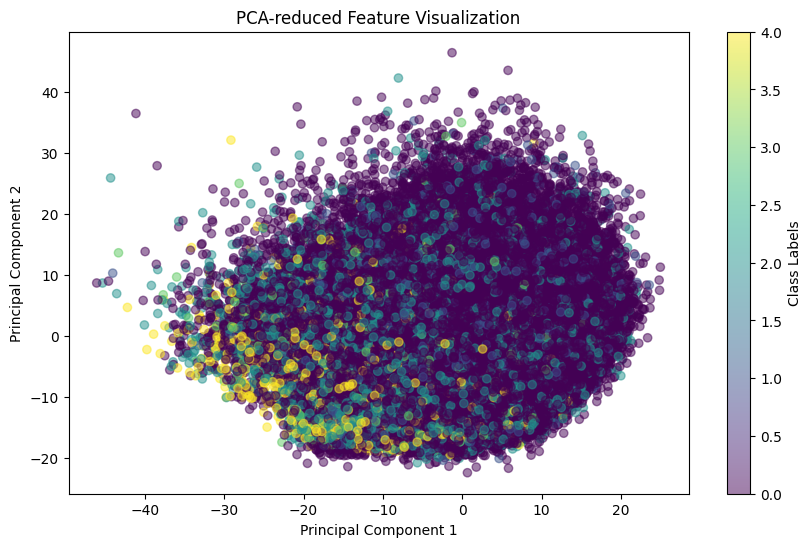

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-reduced Feature Visualization')
plt.show()